# Safe Driver prediction
In this competition, you’re challenged to build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year

By 
- James Dietle @jamesdietle
- Devan Govender @dgovender

Source:
https://github.com/jamesdietle/PortoDriver

Referances:
- Who we are borrowing from Jeremy Howard's Rossman
- https://www.kaggle.com/c/porto-seguro-safe-driver-prediction

## Next Steps
1. Implement predictions on the test set.
2. Validate accuracy

# 1. Dependencies
Things that we need to function or that are just nice
    
    - import functions 
    - correct paths and folders
    - cell noises

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Gives times for each block 
get_ipython().magic('load_ext cellevents')

# Set up paths on computer
path = '/home/jd/data/PortoDriver/'

## Import up sound alert dependencies; I really like sounds
from IPython.display import Audio, display

def allDone():
    #display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
    display(Audio(url='http://starmen.net/mother2/soundfx/eb_win.wav', autoplay=True))
    
def RunningEpochs():
    #display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
    display(Audio(url='http://starmen.net/mother2/soundfx/enterbattle.wav', autoplay=True))

In [3]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.structured import *
from fastai.dataset import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler
import operator


time: 620 ms


# 2. Functions
Functions being run by the program

In [4]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

time: 2.29 ms


In [5]:
# Borrowed from 
# http://www.pythonexample.com/code/gini%20coefficient%20metric/
def gini_normalized(y_pred, targ):
  return gini(y_pred, targ) / gini(y_pred, y_pred)

def gini(actual, pred, cmpcol = 0, sortcol = 1):
  assert( len(actual) == len(pred) )
  all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
  all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
  totalLosses = all[:,0].sum()
  giniSum = all[:,0].cumsum().sum() / totalLosses
  giniSum -= (len(actual) + 1) / 2.
  return giniSum / len(actual)

time: 7.45 ms


In [6]:
from sklearn.metrics import roc_auc_score

inv_log = lambda x : np.exp(x)

def gini_metric(preds, targs):
    preds = inv_log(preds)
    auc = roc_auc_score(y_true=targs, y_score=preds)
    return 2 * auc - 1

time: 2.56 ms


# 3. Load in data
Loads the data we are working with into the program
- Data set provided
- Other unique datasets that would help

We are training to target

In [7]:
samplesub = pd.read_csv(f'{path}sample_submission.csv', low_memory=False)
test = pd.read_csv(f'{path}test.csv', low_memory=False)
train = pd.read_csv(f'{path}train.csv', low_memory=False)

time: 7.52 s


In [8]:
# Sample size to speed everything up
size = 3000
#test = test[:size]
#train = train [:size]

time: 862 µs


In [9]:
samplesub[:5]

,id,target
0,0,0.0364
1,1,0.0364
2,2,0.0364
3,3,0.0364
4,4,0.0364


time: 5.65 ms


In [10]:
test[:5].columns

Index(['id', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01',
       'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06',
       'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11',
       'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin'],
      dtyp

time: 2.04 ms


# 4. Manipulate Data
Prepares the data for training, determines features
- Cuts into sets
- Determines features
- Augments data
	1. More data
	2. Data augmentation
	3. Generalize wel with architectures
	4. Add regularization
    5. Reduce architecture complexity

# 5. Prepare Model
Sets up the model
    - choose optimizer
    - choose format
    - choose loss function

In the train and test data, features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal. Values of -1 indicate that the feature was missing from the observation. The target columns signifies whether or not a claim was filed for that policy holder.

Ind category
'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03',
       'ps_ind_04_cat', 'ps_ind_05_cat', 

ind binary
'ps_ind_06_bin', 'ps_ind_07_bin',
       'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin',
       'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15',
       'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin'
    
reg - continous     
        'ps_reg_01',
       'ps_reg_02', 'ps_reg_03', 

car category
    'ps_car_01_cat', 'ps_car_02_cat',
       'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat',
       'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat',
       'ps_car_11_cat', 'ps_car_11', 'ps_car_12', 'ps_car_13', 
        
car - cont
'ps_car_14',
       'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
       'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
       'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
car - cat
       'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_calc_20_bin']/*

In [11]:
## Move training set over
joined = train

time: 627 µs


In [12]:
# Adding the validation set to the training set
#joined=joined.append(test)

time: 527 µs


In [13]:
## Just changed all of this no idea if it helps
## This works, but appears to break later
joined=joined.replace(-1, np.NaN)
##
#joined=joined.fillna(0)

time: 343 ms


In [14]:
# Should this be changed?
joined.target=joined.target.replace(0, .001)
#joined.target=joined.target.replace(1, .999)

time: 40.3 ms


In [15]:
#joined= joined.set_index('id')

time: 536 µs


In [16]:
joined[:5]

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0.001,2,2.0,5,1.0,0.0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0.001,1,1.0,7,0.0,0.0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0.001,5,4.0,9,1.0,0.0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0.001,0,1.0,2,0.0,0.0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0.001,0,2.0,0,1.0,0.0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


time: 13.9 ms


In [17]:
joined.to_feather(f'{path}joined')

time: 440 ms


## Create Features

In [18]:
joined = pd.read_feather(f'{path}joined')

time: 64.9 ms


In [19]:
joined[:5]

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0.001,2,2.0,5,1.0,0.0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0.001,1,1.0,7,0.0,0.0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0.001,5,4.0,9,1.0,0.0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0.001,0,1.0,2,0.0,0.0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0.001,0,2.0,0,1.0,0.0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


time: 223 ms


In [20]:
cat_vars = [
    #'id', 
    'ps_ind_02_cat', 
       'ps_ind_04_cat', 'ps_ind_05_cat','ps_ind_06_bin', 'ps_ind_07_bin',
       'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin',
       'ps_ind_12_bin', 'ps_ind_13_bin', 
       'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_car_01_cat', 'ps_car_02_cat',
       'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat',
       'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat',
       'ps_car_11_cat',
        'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
    'ps_calc_19_bin', 'ps_calc_20_bin']

contin_vars = ['ps_car_11', 'ps_car_12', 'ps_car_13','ps_ind_14', 'ps_ind_15','ps_ind_01','ps_ind_03','ps_reg_01','ps_reg_02', 'ps_reg_03', 'ps_car_14',
       'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
       'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
       'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14']

n = len(joined); n

595212

time: 6.6 ms


In [21]:
type(cat_vars)

list

time: 1.49 ms


In [22]:
joined[:5]

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0.001,2,2.0,5,1.0,0.0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0.001,1,1.0,7,0.0,0.0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0.001,5,4.0,9,1.0,0.0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0.001,0,1.0,2,0.0,0.0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0.001,0,2.0,0,1.0,0.0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


time: 13.9 ms


In [23]:
samp_size = n
joined_samp = joined

time: 776 µs


In [24]:
joined

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0.001,2,2.0,5,1.0,0.0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0.001,1,1.0,7,0.0,0.0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0.001,5,4.0,9,1.0,0.0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0.001,0,1.0,2,0.0,0.0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0.001,0,2.0,0,1.0,0.0,1,0,0,...,3,1,1,3,0,0,0,1,1,0
5,19,0.001,5,1.0,4,0.0,0.0,0,0,0,...,4,2,0,9,0,1,0,1,1,1
6,20,0.001,2,1.0,3,1.0,0.0,0,1,0,...,3,0,0,10,0,1,0,0,1,0
7,22,0.001,5,1.0,4,0.0,0.0,1,0,0,...,7,1,3,6,1,0,1,0,1,0
8,26,0.001,5,1.0,3,1.0,0.0,0,0,1,...,4,2,1,5,0,1,0,0,0,1
9,28,1.000,1,1.0,2,0.0,0.0,0,1,0,...,3,5,0,6,0,1,0,0,1,0


time: 120 ms


In [25]:
for v in cat_vars: joined[v] = joined[v].astype('category').cat.as_ordered()
for v in contin_vars: joined[v] = joined[v].astype('float32')
dep = 'target'
#joined = joined[cat_vars+contin_vars+[dep,'id']]
joined = joined[cat_vars+contin_vars+[dep,'id']]

time: 966 ms


In [26]:
joined_samp = joined.set_index('id')
#??joined.set_index

time: 19.8 ms


In [27]:
df, y, nas, mapper = proc_df(joined_samp, 'target', do_scale=True)
yl = y
yl

array([ 0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  1.   ,  0.001,  0.001,  0.001,
        0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  1.   , ...,  0.001,  0.001,  0.001,  0.001,  0.001,
        0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,
        0.001,  0.001])

time: 4.26 s


In [28]:
df[:5]

,ps_ind_02_cat,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,...,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_car_11_na,ps_car_12_na,ps_reg_03_na,ps_car_14_na
id,,,,,,,,,,,,,,,,,,,,,
7,2,2,1,1,2,1,1,1,1,1,...,-1.073849,-1.182124,1.525425,-0.367359,1.255373,0.167831,-0.002898,-0.001296,-0.470211,-0.277718
9,1,1,1,1,1,2,1,1,1,1,...,-1.073849,-0.493559,-1.046515,-0.367359,-1.104669,0.531911,-0.002898,-0.001296,-0.470211,-0.277718
13,4,2,1,1,1,2,1,1,1,1,...,-0.271891,-0.493559,-0.617858,0.463923,2.435393,-0.196249,-0.002898,-0.001296,2.126707,-0.277718
16,1,1,1,2,1,1,1,1,1,1,...,1.332025,-2.214970,-1.475171,0.463923,0.665362,0.531911,-0.002898,-0.001296,-0.470211,-0.277718
17,2,2,1,2,1,1,1,1,1,1,...,-0.271891,1.227851,-1.046515,-0.367359,-1.104669,-1.652569,-0.002898,-0.001296,-0.470211,-0.277718


time: 13.4 ms


In [29]:
y[:5]

array([ 0.001,  0.001,  0.001,  0.001,  0.001])

time: 1.66 ms


In [30]:
nas

{'ps_car_11': 3.0,
 'ps_car_12': 0.37416574358940125,
 'ps_car_14': 0.37349697947502136,
 'ps_reg_03': 0.8015609979629517}

time: 1.36 ms


In [31]:
mapper

DataFrameMapper(default=False, df_out=False,
        features=[(['ps_car_11'], StandardScaler(copy=True, with_mean=True, with_std=True)), (['ps_car_12'], StandardScaler(copy=True, with_mean=True, with_std=True)), (['ps_car_13'], StandardScaler(copy=True, with_mean=True, with_std=True)), (['ps_ind_14'], StandardScaler(copy=True, with_mean=True, with_st...True, with_std=True)), (['ps_car_14_na'], StandardScaler(copy=True, with_mean=True, with_std=True))],
        input_df=False, sparse=False)

time: 2.73 ms


In [32]:
len(joined)

595212

time: 1.47 ms


In [33]:
df.index[50]

125

time: 1.52 ms


In [34]:
# makes a 20% validation size
val_idx_list=train['id'].tolist()
len(val_idx_list)
val_idx = random.sample(val_idx_list, int(len(val_idx_list)*.2))
len(val_idx_list), len(val_idx)

(595212, 119042)

time: 113 ms


In [35]:
val_idx.sort()

time: 46.7 ms


In [36]:
## Get the index for something inside the list
val_target=train.target[train['id'].isin(val_idx)].tolist()
val_idx=train.index[train['id'].isin(val_idx)].tolist()
len(val_idx), len(val_target)

(119042, 119042)

time: 67.9 ms


# 6. Runs the training
Run it the training! Save the weights! 
- Make the predictions


In [37]:
max_log_y = np.max(yl)

# 1.2 doesn't make sense
#y_range = (0, max_log_y*1.2)
y_range = (0, max_log_y*1)

time: 1.87 ms


In [38]:
max_log_y,y_range

(1.0, (0, 1.0))

time: 1.55 ms


In [39]:
type(cat_vars),cat_vars[:5]

(list,
 ['ps_ind_02_cat',
  'ps_ind_04_cat',
  'ps_ind_05_cat',
  'ps_ind_06_bin',
  'ps_ind_07_bin'])

time: 1.61 ms


In [40]:
md = ColumnarModelData.from_data_frame(path, val_idx, df, yl, cat_flds=cat_vars, bs=512)

time: 730 ms


In [41]:
yl

array([ 0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  1.   ,  0.001,  0.001,  0.001,
        0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  1.   , ...,  0.001,  0.001,  0.001,  0.001,  0.001,
        0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,
        0.001,  0.001])

time: 2.06 ms


In [42]:
#cat_sz = {c: len(joined_samp[c].cat.categories)+1 for c in cat_vars}
cat_sz = {c: len(joined[c].cat.categories)+1 for c in cat_vars}
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz.items()]

time: 2.79 ms


In [43]:
joined.target.max(),joined.target.min()

(1.0, 0.001)

time: 6.5 ms


In [44]:
joined.dtypes[:5]

ps_ind_02_cat    category
ps_ind_04_cat    category
ps_ind_05_cat    category
ps_ind_06_bin    category
ps_ind_07_bin    category
dtype: object

time: 2.57 ms


In [45]:
type(y_range)

tuple

time: 1.32 ms


In [46]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   #0.04, 1, [1000,500], [0.001,0.01], y_range=None)#y_range)
                   # Has to be between 0, 1
                   0.04, 1, [1000,500], [0.001,0.01], y_range=None)
lr = 1e-3

time: 3min 15s


In [47]:
RunningEpochs()

time: 2.92 ms


In [48]:
m.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 29%|██▊       | 267/931 [00:30<01:15,  8.80it/s, loss=1.08]  time: 30.6 s


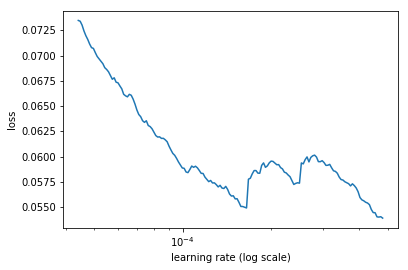

time: 211 ms


In [49]:
m.sched.plot(100)

In [50]:
lr = 1e-3

time: 708 µs


In [51]:
m.fit(lrs=lr, n_cycle=20, cycle_len=3, metrics=[accuracy, gini_normalized])

HBox(children=(IntProgress(value=0, description='Epoch', max=60), HTML(value='')))


  7%|▋         | 64/931 [00:06<01:33,  9.31it/s, loss=0.101]


 10%|▉         | 89/931 [00:09<01:29,  9.37it/s, loss=0.0876]

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/jd/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/jd/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/jd/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration
Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/jd/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/jd/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/jd/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration




[ 0.       0.47042  0.39522  0.       0.01156]                
[ 1.       0.03556  0.04596  0.       0.02541]                
[ 2.       0.03433  0.03557  0.       0.02756]                
[ 3.       0.09056  0.22787  0.       0.03015]                
[ 4.       0.05604  0.03459  0.       0.03386]                
[ 5.       0.03485  0.03442  0.       0.03417]                
[ 6.       0.03359  0.03483  0.       0.03425]                
[ 7.       0.03826  0.03471  0.       0.03336]                
[ 8.       0.03733  0.03442  0.       0.03448]                
[ 9.       0.03657  0.07899  0.       0.02768]                
[ 10.        0.03567   0.03492   0.        0.03687]           
[ 11.        0.03285   0.03476   0.        0.03356]           
[ 12.        0.0348    0.04533   0.        0.02895]           
[ 13.        0.03261   0.03493   0.        0.02838]           
[ 14.        0.03084   0.03511   0.        0.02894]           
[ 15.        0.03414   0.03583   0.        0.03381]    

## Predictions

In [52]:
predictions=m.predict()

time: 1.48 s


In [53]:
len(predictions)

119042

time: 1.54 ms


#create ColumnarDataSet from DataFrame (df)
#cds = ColumnarDataset.from_data_frame(path, val_idx, joined, yl, cat_flds=cat_vars, bs=512)
??ColumnarDataset.from_data_frame
cds = ColumnarDataset.from_data_frame(joined, cat_flds=cat_vars, y=yl)

#create DataLoader from ColumnarDataSet
dl = DataLoader(cds)

#make predictions for DataLoader
predictions = m.predict_dl(dl)

# 7. Analyze Results
Are they what are expected? 
- Graph the results
- What are the most important features
- What do tough predictions look like? Easy predictions?

In [54]:
predictions.max(), predictions.min()

(1.5760945, -0.097676046)

time: 1.62 ms


In [55]:
predictions[:5]

array([[ 0.02697],
       [ 0.02086],
       [-0.01008],
       [ 0.00856],
       [-0.00768]], dtype=float32)

time: 1.67 ms


In [56]:
allDone()

time: 1.39 ms


In [57]:
predictions=m.predict()

time: 1.47 s


In [58]:
predictions=predictions.tolist()

time: 70.1 ms


In [59]:
predictions = [item[0] for item in predictions]

time: 6.73 ms


In [60]:
type(predictions), len(val_idx), len(predictions), len(val_target)

(list, 119042, 119042, 119042)

time: 1.7 ms


In [61]:
## Validation set predicted target... I see I am very far off.
submission = pd.DataFrame({'id': val_idx, 'pred_target': predictions, 'target': val_target})
submission

,id,pred_target,target
0,16,0.026968,0
1,22,0.020856,0
2,33,-0.010084,0
3,41,0.008555,1
4,42,-0.007676,0
5,46,0.017015,0
6,47,0.012099,0
7,55,0.017421,0
8,57,0.031213,0
9,64,0.007034,0


time: 42.4 ms


In [62]:
## Looks at the ones equal to target 1
submission.loc[submission['target'] == 1]

,id,pred_target,target
3,41,0.008555,1
67,297,0.020154,1
70,305,0.004088,1
148,688,0.013590,1
188,845,-0.026651,1
282,1370,-0.020263,1
285,1407,0.000182,1
309,1569,-0.004753,1
373,1882,0.030949,1
394,1980,-0.024636,1


time: 11.4 ms


In [63]:
## Looks at the ones equal to target 0
submission.loc[submission['target'] == 0]

,id,pred_target,target
0,16,0.026968,0
1,22,0.020856,0
2,33,-0.010084,0
4,42,-0.007676,0
5,46,0.017015,0
6,47,0.012099,0
7,55,0.017421,0
8,57,0.031213,0
9,64,0.007034,0
10,66,0.005369,0


time: 12.6 ms


# 8. Submit!
- Get it put into a submitable template
- Save results

In [64]:
## Sets up the 
submission = pd.DataFrame({'id': val_idx, 'target': predictions})
# Shows 5 to ensure formatting is correct
submission[:5]

,id,target
0,16,0.026968
1,22,0.020856
2,33,-0.010084
3,41,0.008555
4,42,-0.007676


time: 24.4 ms


In [65]:
# Makes the submission name out of folders
path2 = path +'submits/'
## labels submissions in order
numFiles=len(os.listdir(path2))
subm_name = 'submission'+str(numFiles)+'.csv.gz'

time: 1.41 ms


In [66]:
## prints it out to downloaded
submission.to_csv((path2+subm_name), index=False, compression='gzip')
print ('http://localhost:8888/view/data/PortoDriver/submits/'+subm_name)

http://localhost:8888/view/data/PortoDriver/submits/submission4.csv.gz
time: 771 ms
